# MAR Analysis of Missing Value of Disease Onset Date

## Imports and Settings

In [1]:
import pandas as pd
import numpy as np

In [2]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [3]:
import plotly.io as pio
pio.renderers.default = "svg"

In [4]:
from sklearn.preprocessing import OneHotEncoder

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.model_selection import cross_validate

## Data Loading and Preparation

In [5]:
delay = pd.read_pickle("../../data/processed/delay_2020-04-15.pl")

#### Summarize all observations which do not have known or binary gender

In [6]:
delay.loc[(delay["gender"]!="male") & (delay["gender"]!="female"),"gender"] = "other"

#### Remove observations with negative reporting delay

In [7]:
delay = delay[(delay["reporting_delay_hd"]>=0) | (delay["reporting_delay_hd"].isnull())]

#### One-Hot Encoding (Dummy Variables)

In [8]:
def to_dummy(X):
    enc = OneHotEncoder(handle_unknown='error',sparse=False,drop="first")
    X_cat = X.select_dtypes(include=[object,"category"])
    X_num = X.select_dtypes(exclude=[object,"category"])
    X_trans = pd.DataFrame(enc.fit_transform(X_cat),columns=enc.get_feature_names(X_cat.columns),index=X.index)
    X_dummy = pd.concat([X_num,X_trans],axis=1)
    return X_dummy, enc, X_cat.columns

def from_dummy(X, enc, cat_columns):
    X_trans = X[enc.get_feature_names(cat_columns)]
    X_num = X.drop(enc.get_feature_names(cat_columns),axis=1)
    X_cat = pd.DataFrame(enc.inverse_transform(X_trans),columns=cat_columns,index=X.index)
    X_res = pd.concat([X_num,X_cat],axis=1)
    return X_res

In [9]:
delay_labels = ["week_report","weekday_report","age","gender","state"]
delay[delay_labels].isnull().sum()

week_report       0
weekday_report    0
age               0
gender            0
state             0
dtype: int64

In [10]:
delay_dummy, enc, enc_cats = to_dummy(delay[delay_labels])
y = delay["reporting_delay_hd"].isnull()

## Predict Missingness
The approach to invalidate the *Missing at Random (MAR) - Hypothesis* is to try to predict missingness using a regression model. If that is possible with decent performance, there must be a bias in the covariates.

In [11]:
models = {"dummy": DummyClassifier(strategy="stratified"),
          "knn": KNeighborsClassifier(3),
          "decision_tree": DecisionTreeClassifier(max_depth=20,class_weight="balanced"),
         "random forest":  RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)}
scorings = ["accuracy","precision","recall","f1"]

#### Test prediction of missingness using other features

In [12]:
cv_results = pd.concat([pd.DataFrame(cross_validate(model, delay_dummy, y, scoring=scorings, cv=5)).assign(model=modelname) for modelname, model in models.items()])
cv_results.groupby("model").mean()

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1
model,,,,,,
decision_tree,0.357294,0.063645,0.404876,0.275545,0.383955,0.309430
dummy,0.018222,0.025961,0.532913,0.373816,0.368883,0.370462
knn,0.498161,16.393009,0.468879,0.296306,0.320030,0.289525
random forest,0.233185,0.110303,0.597308,0.551102,0.144023,0.101983


#### Test prediction of missingness using randomly permuted features (zero information)

In [13]:
delay_dummy_shuffled = delay_dummy.copy()
for c in delay_dummy_shuffled.columns:
    delay_dummy_shuffled[c] = delay_dummy_shuffled.loc[np.random.permutation(delay_dummy_shuffled.index),c].to_numpy()

In [14]:
cv_results_shuffled = pd.concat([pd.DataFrame(cross_validate(model, delay_dummy_shuffled, y, scoring=scorings, cv=5)).assign(model=modelname) for modelname, model in models.items()])
cv_results_shuffled.groupby("model").mean()

C:\Users\User\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples.

C:\Users\User\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no predicted samples.

C:\Users\User\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples.

C:\Users\User\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no predicted samples.

C:\Users\User\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples.

C:\Users\User\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: Undefin

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1
model,,,,,,
decision_tree,0.528786,0.069761,0.506701,0.371500,0.471451,0.415190
dummy,0.017959,0.026329,0.532245,0.374252,0.373681,0.371163
knn,0.384419,23.098028,0.548698,0.370895,0.305993,0.335324
random forest,0.258765,0.116082,0.627949,0.000000,0.000000,0.000000


### Preliminary Conclusion
The extremely weak results of classification attempts for missing values (dummy models without variable usage perform on par, performance scores with randomly permuted features are not worse) of the reported onset date indicate that the other covariates are not clearly related to the missingness. This does not imply that (a fraction of) the data may be missing with other patterns. Nevertheless, it can be rather savely assumed that there is no strong relationship between the other variables and the missingness of the date of disease onset.

### Deprecated code

#### Logistic Regression with Scikit-Learn

In [40]:
from sklearn.linear_model import LogisticRegression

In [43]:
cl_miss = LogisticRegression(random_state=0,solver="lbfgs",max_iter=400).fit(X_dummy, y)

In [44]:
pd.Series(cl_miss.coef_[0],index=X_dummy.columns)

day_confirmation                0.062841
age                             0.005044
gender_weiblich                 0.013231
state_Bayern                    0.685387
state_Berlin                   -0.693047
state_Brandenburg              -0.861278
state_Bremen                   -0.630790
state_Hamburg                   0.337778
state_Hessen                   -0.377047
state_Mecklenburg-Vorpommern   -0.328505
state_Niedersachsen            -0.087093
state_Nordrhein-Westfalen      -0.213614
state_Rheinland-Pfalz           0.302931
state_Saarland                  0.490397
state_Sachsen                   0.418214
state_Sachsen-Anhalt           -0.752184
state_Schleswig-Holstein       -0.597713
state_Thüringen                -1.294836
dtype: float64

#### Classification with Decision Tree

In [1]:
from sklearn import tree
from sklearn.model_selection import cross_validate

In [2]:
indx = X_dummy.sample(frac=1).index
scorings = ["accuracy","precision","recall","f1"]
learner = tree.DecisionTreeClassifier(max_depth=20,class_weight="balanced")
pd.DataFrame(cross_validate(learner, delay_dummy.loc[indx,], y[indx], scoring=scorings, cv=5))

NameError: name 'X_dummy' is not defined

In [49]:
clf = tree.DecisionTreeClassifier(max_depth=20,class_weight="balanced")
clf = clf.fit(delay_dummy, y)

In [50]:
pd.Series(clf.feature_importances_,index=delay_dummy.columns)

day_confirmation                0.400150
age                             0.333005
gender_weiblich                 0.055167
state_Bayern                    0.117242
state_Berlin                    0.010718
state_Brandenburg               0.007122
state_Bremen                    0.002300
state_Hamburg                   0.006560
state_Hessen                    0.007047
state_Mecklenburg-Vorpommern    0.002075
state_Niedersachsen             0.005000
state_Nordrhein-Westfalen       0.011956
state_Rheinland-Pfalz           0.011745
state_Saarland                  0.005394
state_Sachsen                   0.007256
state_Sachsen-Anhalt            0.004115
state_Schleswig-Holstein        0.005812
state_Thüringen                 0.007335
dtype: float64

In [51]:
from sklearn import metrics

In [52]:
print(f"Precision: {metrics.precision_score(y,clf.predict(delay_dummy)):5f}")
print(f"Recall: {metrics.recall_score(y,clf.predict(delay_dummy)):5f}")
print(f"F1: {metrics.f1_score(y,clf.predict(delay_dummy)):5f}")

Precision: 0.670543
Recall: 0.674781
F1: 0.672655


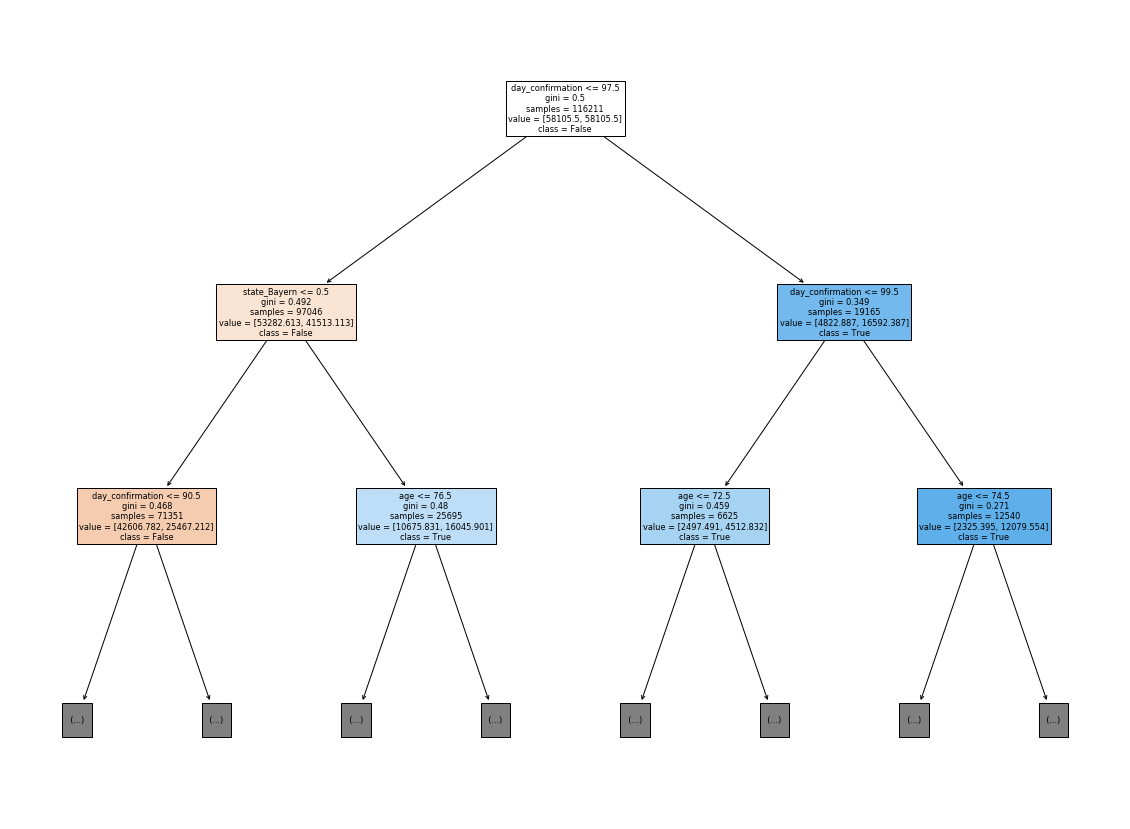

In [54]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,15))
fig = tree.plot_tree(clf,max_depth=2,class_names=["False","True"],filled=True,feature_names=delay_dummy.columns)